In [16]:
import numpy as np
import pandas as pd

# Michaud's method of efficient frontier

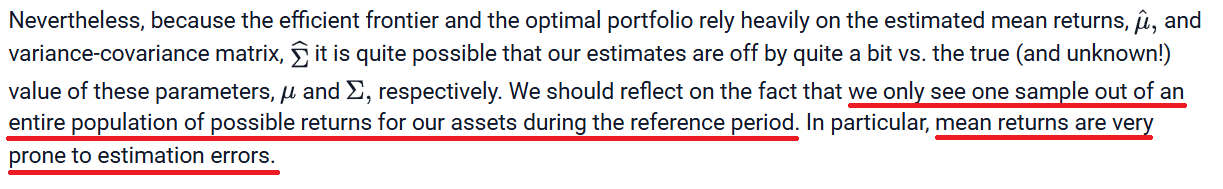

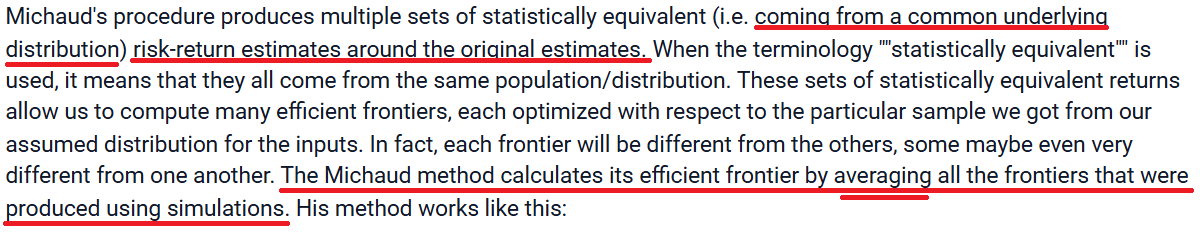

## Step 1) Estimate mean returns vector $\hat{\mu}$ and covariance matrix $\hat{\Sigma}$

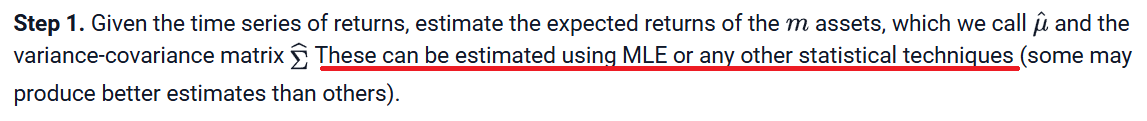

## Step 2) Calculate the <u>constrained</u> weights of the <u>minimum variance portfolio</u> $(w_{minvar})$ and <u>maximum return portfolio</u> $(w_{maxr})$

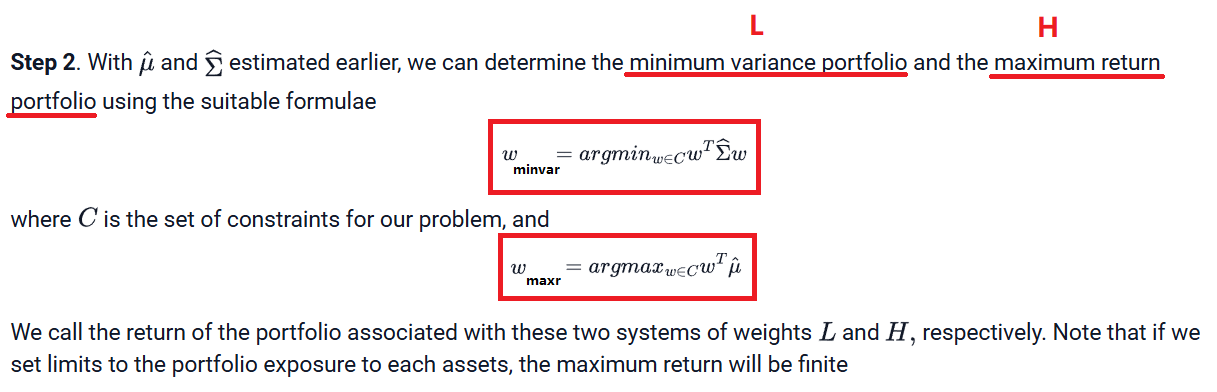

where,

$\Large L = r_{minvar} = {w_{minvar}}^T \hat{\mu}$

$\Large H = r_{maxr} = {w_{maxr}}^T \hat{\mu}$

    Notice that L and H are scalar, not vector.

## Step 3) 

_________

# Mean-Variance Optimization Process

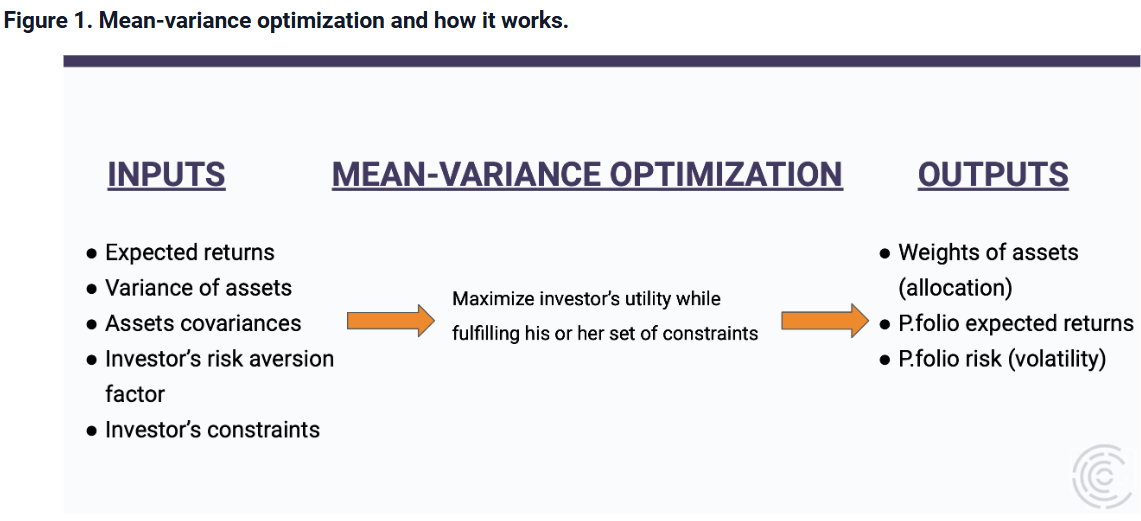

## Co-Skewness

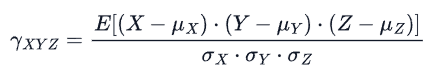

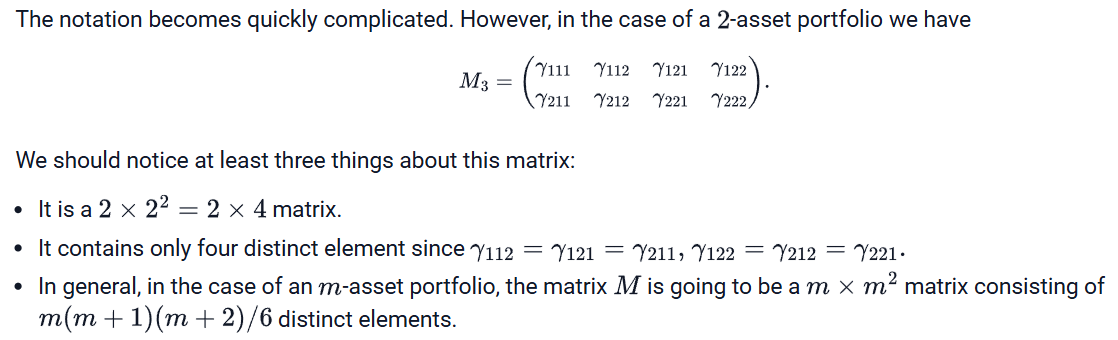

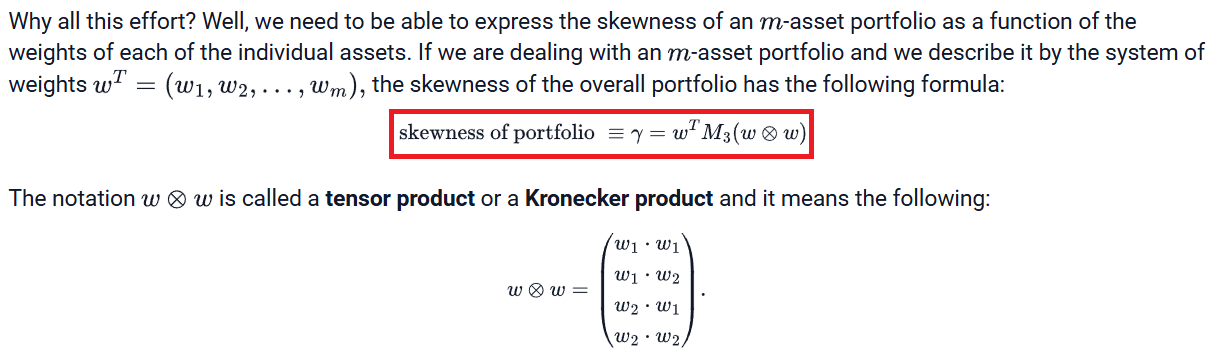

where,

$\Large M_3:$ co-skewness matrix.

In [17]:
def calc_portfolio_skewness(w, M3):
    if w.ndim == 1:
        w = w[:, np.newaxis]  # Ensure w is a column vector
    skewness = w.T @ M3 @ np.kron(w, w)
    return skewness

In [18]:
M3 = np.array([
    [0.2, 0.1, 0.1, 0.3],
    [0.1, 0.3, 0.3, 0.5]
])

w = np.array([0.4, 0.6])

calc_portfolio_skewness(w, M3)

array([[0.2792]])

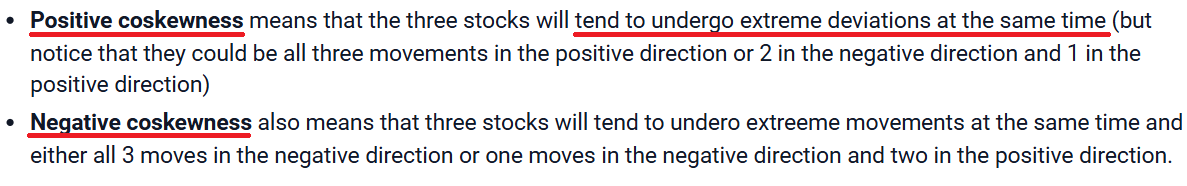

# Co-Kurtosis

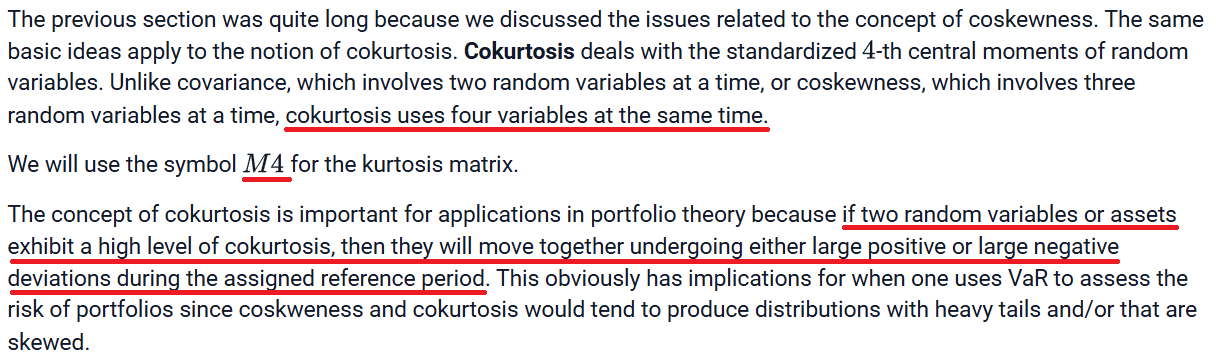

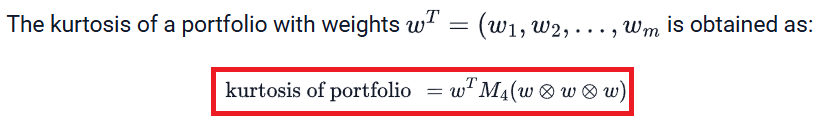

where,

$\Large M_4:$ Co-kurtosis matrix

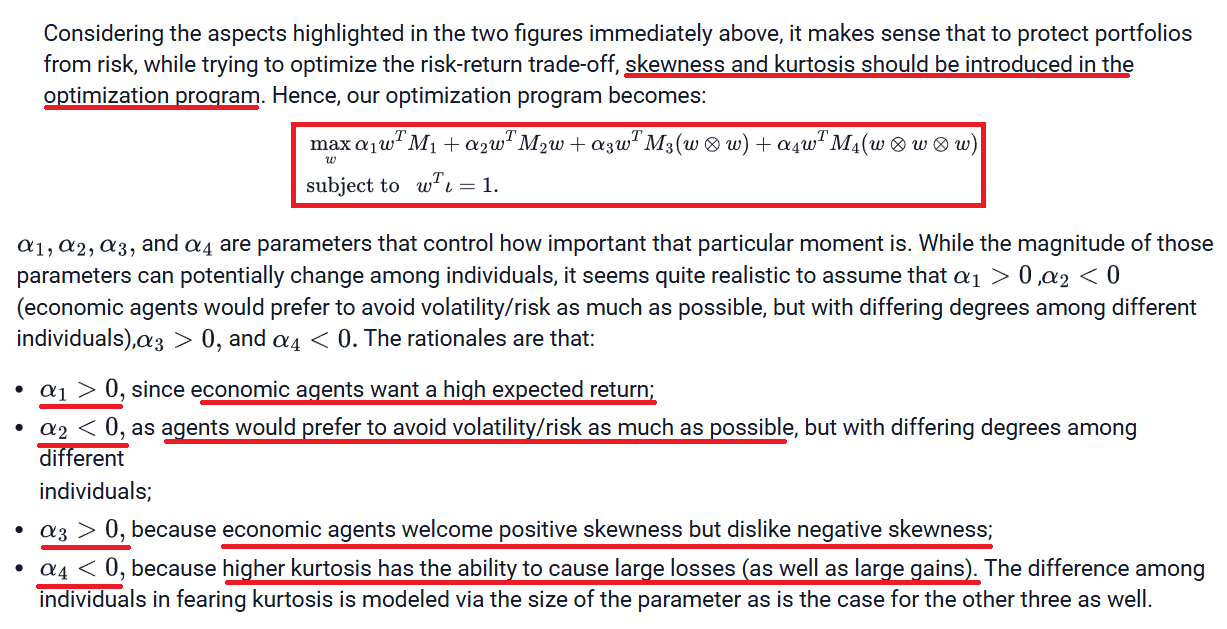

# Liquidity Constraints

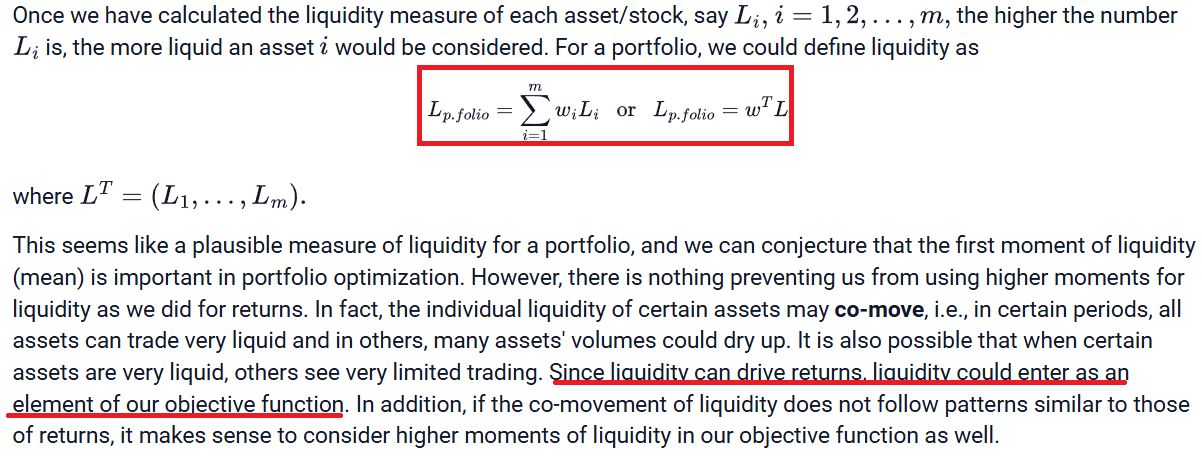

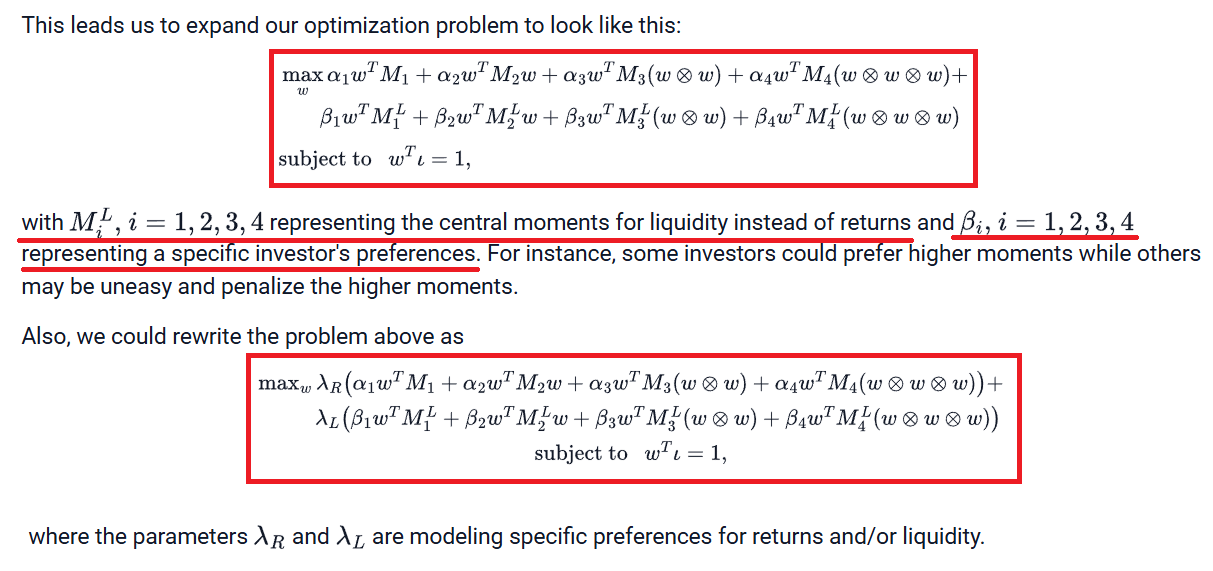

# Optimization Process & Code

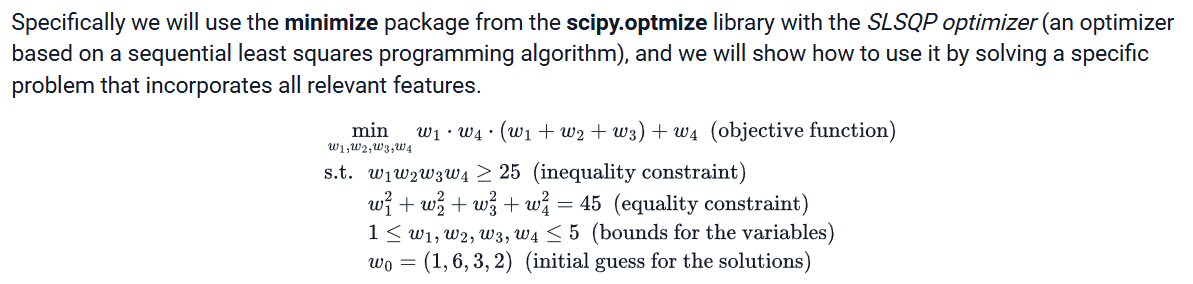

In [ ]:
import numpy as np
from scipy.optimize import minimize  # load the package minimize

cons1_value = 25.0
cons2_value = 45.0

def objective(w):  # define the objective function to minimize.
   return w[0]*w[3]*(w[0]+w[1]+w[2])+w[3]

def constraint1(w):   # define the typical inequality constraint
   return w[0]*w[1]*w[2]*w[3] - cons1_value

def constraint2(w):   # define the prototypical equality constraint.
   return w[0]**2 + w[1]**2 + w[2]**2 + w[3]**2 - cons2_value

# initial weights
w0 = (1,6,3,2)

# show initial objective using the initial solution
print('Initial Objective: '+ str(objective(w0)))

# optimize
b = (1.0,5.0)
bnds = (b, b, b, b)   # define the interval bounds for each of the variables.
con1 = {'type': 'ineq', 'fun': constraint1}  # tell the program the type of constr.
con2 = {'type': 'eq', 'fun': constraint2}   # tell the program the type of constr.
cons = ([con1,con2])    # this is the list of constraints the program will receive
solution = minimize(objective,w0,method='SLSQP', bounds=bnds,constraints=cons)
w = solution.x

# show final objective
print('Final Objective: ' + str(objective(w)))

# print solution
print('Solution')
print('w1 = ' + str(w[0]))
print('w2 = ' + str(w[1]))
print('w3 = ' + str(w[2]))
print('w4 = ' + str(w[3]))


Initial Objective: 22
Final Objective: 13.174300499498685
Solution
w1 = 1.0353461481628639
w2 = 4.6176787174702865
w3 = 4.617652555467908
w4 = 1.1324250545689547


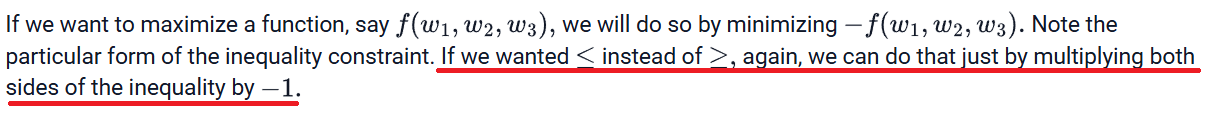

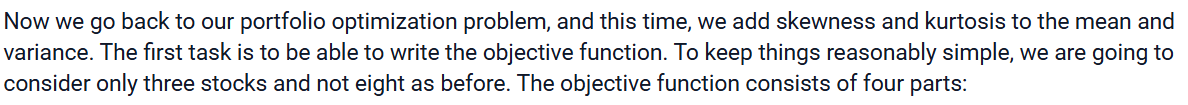

In [22]:
import sympy as sy
import numpy as np
import pandas as pd
import math
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data

### define the stocks from which we want the data (via tickers) ###
#assets = ["AAPL", "MSFT","AMZN","GOOGL","META","TSLA","AMGN", "V"]
assets_list = ["AAPL", "MSFT", "AMZN"] # we worked with a reduced dataset to simplify
# Define the start date
start_date = "2015-01-2"
end_date = "2022-01-15"
# Today's date
#today = datetime.today().strftime('%Y-%m-%d')
# Create an empty dataframe
df_prices = pd.DataFrame()
# Get the  "Adj Close" data from Yahoo Finance
def YahooData(dataframe,assets_list,start_date,end_date):
    for i in assets_list:
        dataframe[i] = yf.download(i, start=start_date, end=end_date)['Close']
    return dataframe
df1 = YahooData(df_prices,assets_list, start_date,end_date)
# We transform the data to it´s logarithmic returns
df = np.log(df1).diff()
# Drop the first row because we loose information we the logarithmic return.
df = df.dropna()

# compute coskewness matrix

num = len(df.columns)
numc = len(df)
M3 = np.zeros(shape = (num, num**2))
v = df.values
means = v.mean(0,keepdims=True)
v1 = (v-means).T

for i in range(num):
    for j in range(num):
        for k in range(num):
            u = 0.0
            for t in  range(numc):
                u=u+v1[i,t]*v1[j,t]*v1[k,t]

            M3[i, j*num+k] = u/float((len(df)-1)\
            *df.iloc[:,i].std()*df.iloc[:,j].std()*df.iloc[:,k].std())

M3

# Compute the cokurtosis matrix

num = len(df.columns)
numc = len(df)
M4 = np.zeros(shape = (num, num**3))
v = df.values
means = v.mean(0,keepdims=True)
v1 = (v-means).T
for i in range(num):
    for j in range(num):
        for h in range(num):
            for k in range(num):
                u = 0.0
                for t in  range(numc):
                    u=u+v1[i,t]*v1[j,t]*v1[h,t]*v1[k,t]

                M4[i, j*num**2+ h*num+k] = u/float((len(df)-1)\
                *df.iloc[:,i].std()*df.iloc[:,j].std()*df.iloc[:,h].std()\
                *df.iloc[:,k].std())

M4

w1 = sy.Symbol('w1')
w2 = sy.Symbol('w2')
w3 = sy.Symbol('w3')
w =[w1,w2,w3]

M1 = np.round(v.mean(0,keepdims=True),6)
# define mean of portfolio
meanP = sy.simplify(np.dot(w, M1.T))

M2 = df.cov()

# define variance of portfolio.
varP = np.dot(np.dot(w, M2), w)
varP= sy.simplify(varP)

h = np.dot(w, M3)
k =np.kron(w,w)
# define skewness of portfolio
skewP =sy.simplify(np.dot(h,k))

p= np.kron(w, w)
q =np.kron(w, p)
r = np.dot(w, M4)
# define kurtosis of portfolio
kurtP = sy.simplify(np.dot(r, q))

print("Portfolio mean:",   meanP)
print("Portfolio variance:", varP)
print("Portfolio skewness:", skewP)
print("Portfolio kurtosis:", kurtP)


C:\Users\adevr\AppData\Local\Temp\ipykernel_2572\492808653.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dataframe[i] = yf.download(i, start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\adevr\AppData\Local\Temp\ipykernel_2572\492808653.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dataframe[i] = yf.download(i, start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\adevr\AppData\Local\Temp\ipykernel_2572\492808653.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dataframe[i] = yf.download(i, start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed


Portfolio mean: [0.001098*w1 + 0.001139*w2 + 0.001328*w3]
Portfolio variance: 0.000334313778324317*w1**2 + 0.000426582641649771*w1*w2 + 0.000387378199492665*w1*w3 + 0.000288908586216318*w2**2 + 0.000414631201075422*w2*w3 + 0.000354282054862505*w3**2
Portfolio skewness: -0.305645901857439*w1**3 - 1.16512922643038*w1**2*w2 - 0.611834993940643*w1**2*w3 - 0.978727722423374*w1*w2**2 - 1.05961439051847*w1*w2*w3 - 0.451160858999496*w1*w3**2 - 0.222914502866126*w2**3 + 0.0187530487681867*w2**2*w3 + 0.208278404804936*w2*w3**2 + 0.467514069152859*w3**3
Portfolio kurtosis: 9.41322584957254*w1**4 + 30.9611210267652*w1**3*w2 + 18.3158141745914*w1**3*w3 + 51.1235192003237*w1**2*w2**2 + 52.793208475233*w1**2*w2*w3 + 20.7565632988317*w1**2*w3**2 + 39.5357901865067*w1*w2**3 + 58.9102395381564*w1*w2**2*w3 + 42.7914079766232*w1*w2*w3**2 + 11.7298182802304*w1*w3**3 + 13.8400763344102*w2**4 + 27.6596578996929*w2**3*w3 + 33.0003436689212*w2**2*w3**2 + 18.1713299231254*w2*w3**3 + 9.23793229313753*w3**4


In [24]:
alpha1 = -1   # note! The signs have been changed to switch the
alpha2 = +1/2 # maximization program to a minimization one.
alpha3 = -1
alpha4 = 1
def mean(w):
    return alpha1*(0.001072*w[0] + 0.001099*w[1] + 0.001288*w[2])

def var(w):
    return alpha2*(0.000335*w[0]**2 + 0.000428*w[0]*w[1] + 0.000392*w[0]*w[2]+ 0.00029*w[1]**2 + 0.000422*w[1]*w[2] + 0.000369*w[2]**2)

def skew(w):
    return alpha3*(0.27365*w[0]**3 - 1.11516*w[0]**2*w[1] - 0.56307*w[0]**2*w[2]
- 0.9627*w[0]*w[1]**2 - 1.04442*w[0]*w[1]*w[2] - 0.46659*w[0]*w[2]**2 
 - 0.2243*w[1]**3 - 0.02658*w[1]**2*w[2] + 0.16305*w[1]*w[2]**2 + 0.52807*w[2]**3)

def kurt(w):
    return alpha4*(9.36158*w[0]**4 + 30.61548*w[0]**3*w[1] + 17.86736*w[0]**3*w[2]
 + 50.36082*w[0]**2*w[1]**2 + 51.23004*w[0]**2*w[1]*w[2] + 19.875*w[0]**2*w[2]**2
 + 38.88744*w[0]*w[1]**3 + 57.08256*w[0]*w[1]**2*w[2] + 40.94832*w[0]*w[1]*w[2]**2
     + 11.10984*w[0]*w[2]**3 + 13.61024*w[1]**4 + 26.82224*w[1]**3*w[2]
     + 31.76712*w[1]**2*w[2]**2 + 17.96152*w[1]*w[2]**3 + 9.70931*w[2]**4)

def objective(w):
   return mean(w)+var(w)+skew(w) + kurt(w)

# For the constraint, in this case

def constraint1(w):
   return w[0]+w[1]+w[2]-1.0

# for the initial guess, instead, let's use the portfolio that assigns the same weight to each asset:

n = 3
w0 = np.zeros(n)
w0[0] = 0.333
w0[1] = 0.333
w0[2] = 0.333

# And now we can complete the code.

# show initial objective
print('Initial Objective: ' + str(objective(w0)))

b = (0,10000)  #short selling is not allowed
bnds = (b, b, b)
con1 = {'type': 'eq', 'fun': constraint1}
cons = ([con1])
solution = minimize(objective,w0,method='SLSQP',
                   bounds=bnds,constraints=cons)
w = solution.x

# show final objective
print('Final Objective: ' + str(objective(w)))

# print solution
print('Solution')
print('w1 = ' + str(w[0]))
print('w2 = ' + str(w[1]))
print('w3 = ' + str(w[2]))


Initial Objective: 5.379044158345797
Final Objective: 4.229455361812177
Solution
w1 = 0.45074095371507183
w2 = 2.168404344971009e-18
w3 = 0.5492590462849282


___________

# FX Calculations

In [25]:
def calc_forward_parity(S, rd, rf, YF):
    # assumes simple interest rates
    return S * (1+ rd * YF) / (1 + rf * YF)

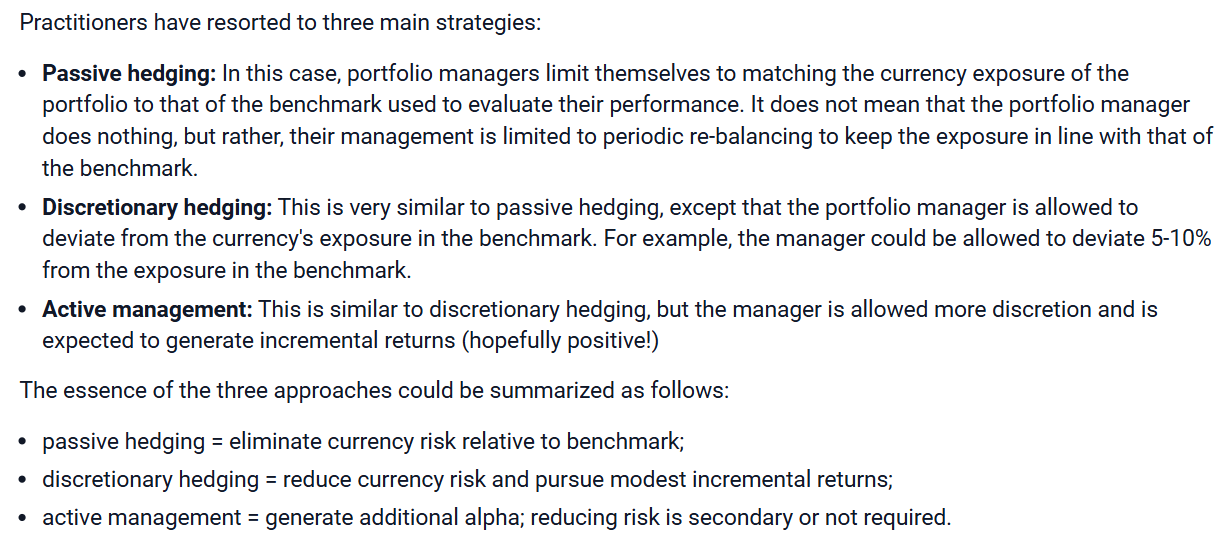

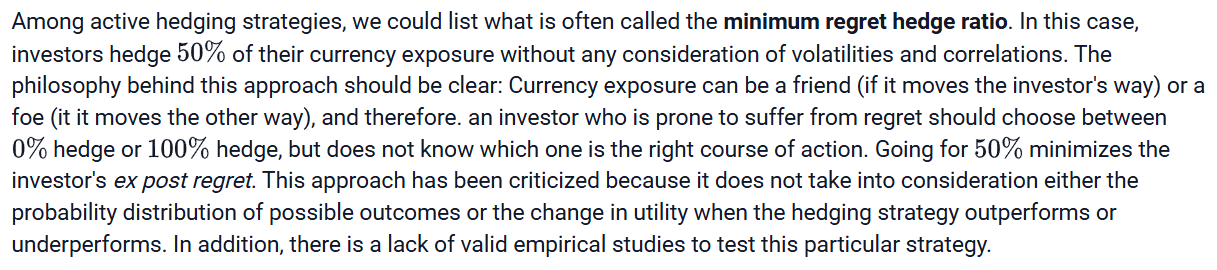

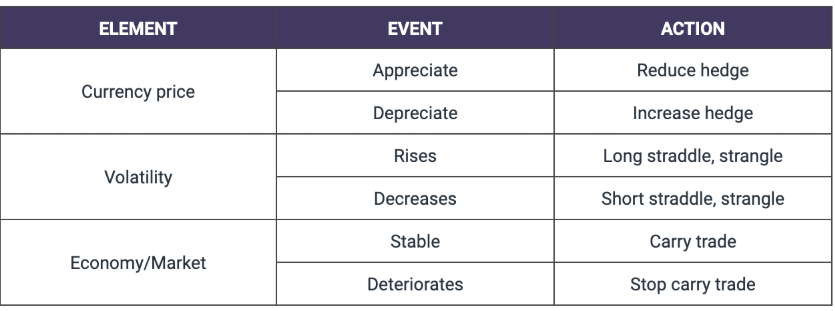

____________

# Risk Factor Models

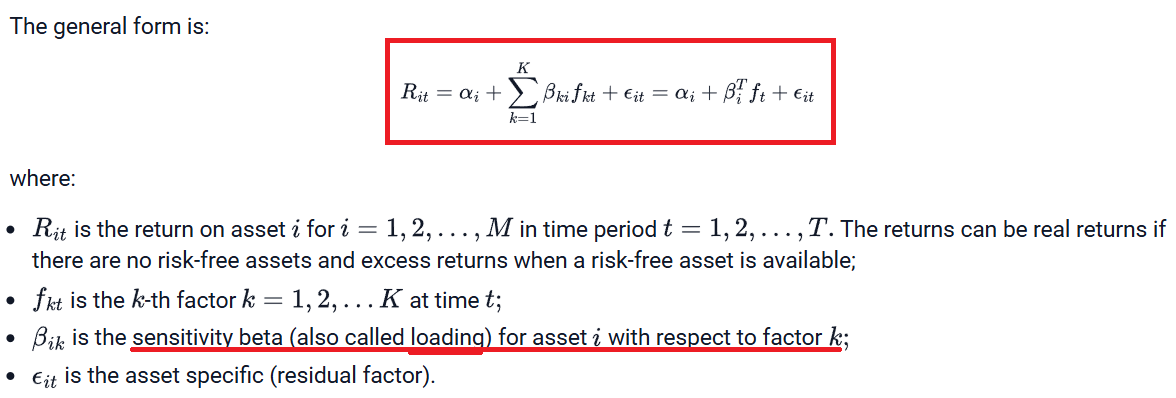

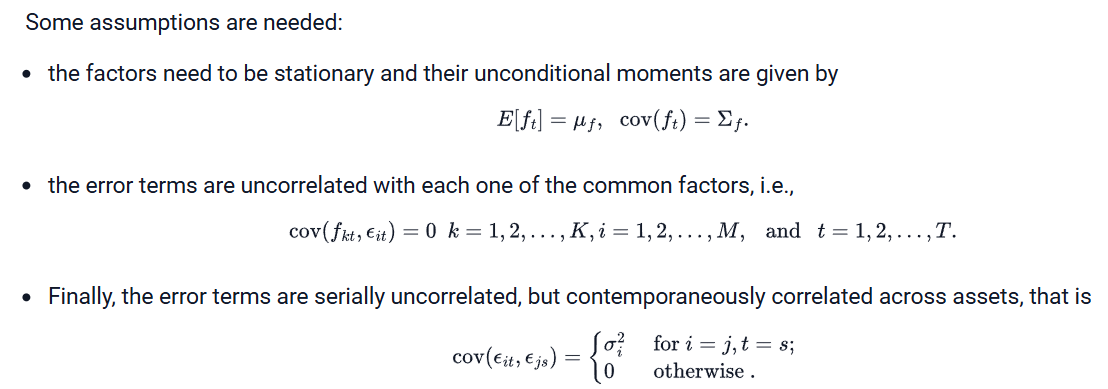

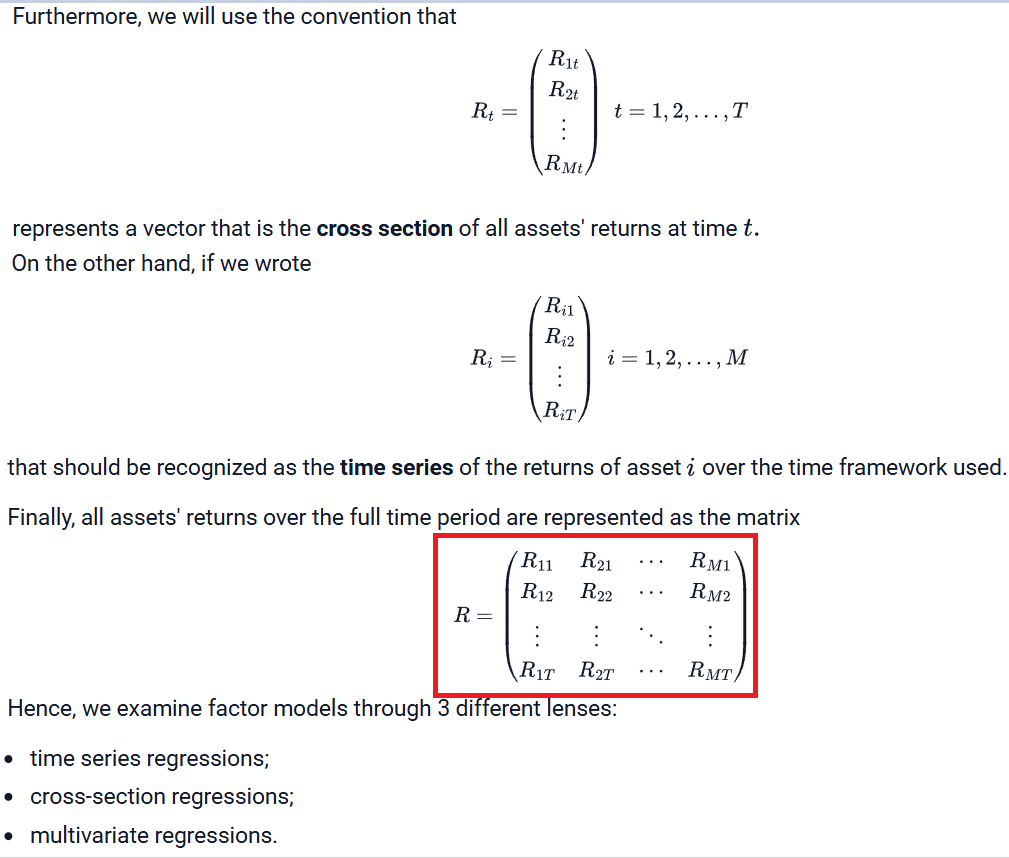

## Cross-asset formula:

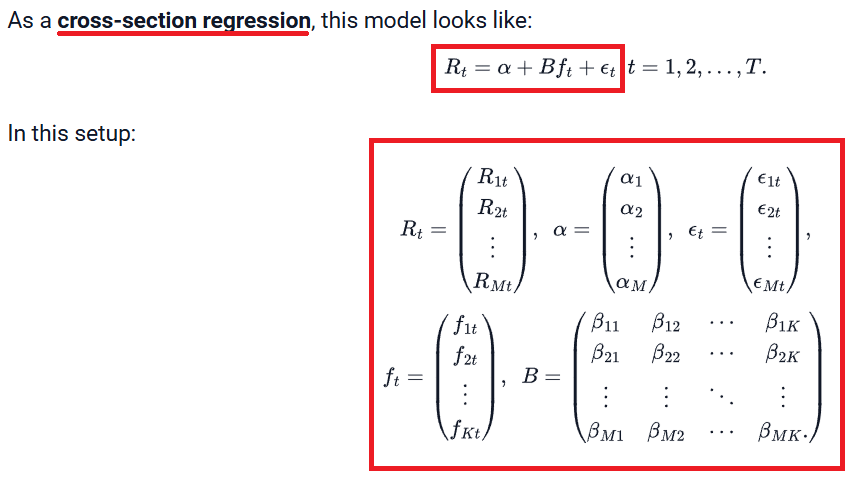

________

# CRT 1

* $\R_1:$ Random return of stock 1.
* $\R_2:$ Random return of stock 2.

* $\mu_1:$ Mean return of stock 1, $\quad \mathbb{E}[R_1] = \mu_1$
* $\mu_2:$ Mean return of stock 1, $\quad \mathbb{E}[R_1] = \mu_2$

* $\sigma_1^2:$ Variance of stock 1, $\quad \sigma_1^2 = \mathbb{E}[(R_1 - \mu_1)^2]$
* $\sigma_2^2:$ Variance of stock 2, $\quad \sigma_2^2 = \mathbb{E}[(R_2 - \mu_2)^2]$

* $\sigma_{21} = \sigma_{12} = \text{Cov}(R_1, R_2) = \mathbb{E}[(R_1 - \mu_1)(R_2 - \mu_2)] $

* $\Sigma:$ Covariance matrix, $\quad \Sigma =
\begin{bmatrix}
\sigma_1^2 & \sigma_{12} \\
\sigma_{21} & \sigma_2^2
\end{bmatrix}
$

* $\Sigma^{-1}:$ Inverse of covariance matrix, $\quad \Sigma^{-1} = \frac{1}{D}
\begin{bmatrix}
\sigma_2^2 & -\sigma_{12} \\
-\sigma_{21} & \sigma_1^2
\end{bmatrix}
, \quad D = \sigma_1^2 \sigma_2^2 - \sigma_{12}^2 = \sigma_1^2 \sigma_2^2 (1 - \rho_{12}^2) $